# Survival Analysis On Colon Cancer

## by Ruben Olmos

# Abstract

Colorectal cancer (CRC), also known as colon cancer is the development of cancer from the colon or rectum (parts of the large intestine). Signs and symptoms may include blood in the stool, a change in bowel movements, weight loss, and feeling tired all the time. Globally more than 1 million people get colorectal cancer every year, resulting in about 715,000 deaths in 2010. In this project we will use KL-estimator and Cox Proportional Hazards model to see 
affects the survival rate over time, using the right-censored dataset of 1858 patients.

## Data Information

The data is sourced from *Chemotherapy For Stage B/C Colon Cancer*, which is available in R package *"survival"*. You can get the data set from the R documentation: https://www.rdocumentation.org/packages/survival/versions/3.1-7/topics/colon.

The dataset includes the survival data of 1858 patients in the US. The unit of observation is the patient and the event of interest are recurrence and death, and the data has some censoring events. For the covariates, Levamisole is a low-toxicity compound previously used to treat worm infestations in animals; 5-FU is a moderately toxic (as these things go) chemotherapy agent.

The variables are:
* id:	id of patient
* study:	1 for all patients
* rx:	Treatment - Obs(ervation), Lev(amisole), Lev(amisole)+5-FU
* sex:	1 for male
* age:	in years
* obstruct:	obstruction of colon by tumour
* perfor:	perforation of colon
* adhere:	adherence to nearby organs
* nodes:	number of lymph nodes with detectable cancer
* time:	days until event or censoring
* status:	censoring status
* differ:	differentiation of tumour (1=well, 2=moderate, 3=poor)
* extent:	Extent of local spread (1=submucosa, 2=muscle, 3=serosa, 4=contiguous structures)
* surg:	time from surgery to registration (0=short, 1=long)
* node4:	more than 4 positive lymph nodes
* etype:	event type: 1=recurrence,2=death

## Data Packages Used

In [42]:
library(dplyr)
library(survival)
library(survminer)
library(ggplot2)
library(knitr)
library(devtools)
library(ggkm)
data("colon")

## Research Question

I am interested in which treatment do have a significant effect on survival rate. And I want to know that whether different groups have different survival curve. In addition, I want to see if there is any interaction between any of covariates. 

## Data Exploration

First we need to check is the data has some NA value. By using the *is.na* function, we could find that variable *nodes* and *differ* has 36 and 46 NAs respectively.

In [5]:
apply(colon,2,function(x) sum(sapply(x, is.na)))

id    study       rx      sex      age obstruct   perfor   adhere 
       0        0        0        0        0        0        0        0 
   nodes   status   differ   extent     surg    node4     time    etype 
      36        0       46        0        0        0        0        0

As our data has 1858 samples, we could just remove those rows that include NA value, witout losing much information. Check the data again there is none NA values.

In [6]:
data = colon[apply(is.na(colon),1,sum) == 0,]
data$sex = as.factor(data$sex)
data$status = as.factor(data$status)
data$surg = as.factor(data$surg)
data$node4 = as.factor(data$node4)
data$etype = as.factor(data$etype)
apply(data,2,function(x) sum(sapply(x, is.na)))

id    study       rx      sex      age obstruct   perfor   adhere 
       0        0        0        0        0        0        0        0 
   nodes   status   differ   extent     surg    node4     time    etype 
       0        0        0        0        0        0        0        0

We now have no values that have an NA value and can proceed to apply a survival analysis.

## Description Statistics

In [7]:
summary(data)

       id            study         rx      sex          age       
 Min.   :  1.0   Min.   :1   Obs    :610   0:856   Min.   :18.00  
 1st Qu.:234.8   1st Qu.:1   Lev    :588   1:920   1st Qu.:53.00  
 Median :466.5   Median :1   Lev+5FU:578           Median :61.00  
 Mean   :466.5   Mean   :1                         Mean   :59.81  
 3rd Qu.:700.2   3rd Qu.:1                         3rd Qu.:69.00  
 Max.   :929.0   Max.   :1                         Max.   :85.00  
    obstruct          perfor            adhere           nodes        status 
 Min.   :0.0000   Min.   :0.00000   Min.   :0.0000   Min.   : 0.000   0:900  
 1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:0.0000   1st Qu.: 1.000   1:876  
 Median :0.0000   Median :0.00000   Median :0.0000   Median : 2.000          
 Mean   :0.1926   Mean   :0.03041   Mean   :0.1441   Mean   : 3.663          
 3rd Qu.:0.0000   3rd Qu.:0.00000   3rd Qu.:0.0000   3rd Qu.: 5.000          
 Max.   :1.0000   Max.   :1.00000   Max.   :1.0000   Max.   :33

For some factor covariates, we find that 73.2% of the people recently had a surgery, 73.5% of the patients have more than 4 positive lymph nodes. 48.2% of the individuals are female, nearly 33% of the patients received treatment Lev(amisole), and another 33% Lev(amisole)+5-FU. The pir chart of the extent of local spread is:



|group                 | value|percent |
|:---------------------|-----:|:-------|
|submucosa             |    38|2.1%    |
|muscle                |   204|11.5%   |
|serosa                |  1460|82.2%   |
|contiguous structures |    74|4.2%    |

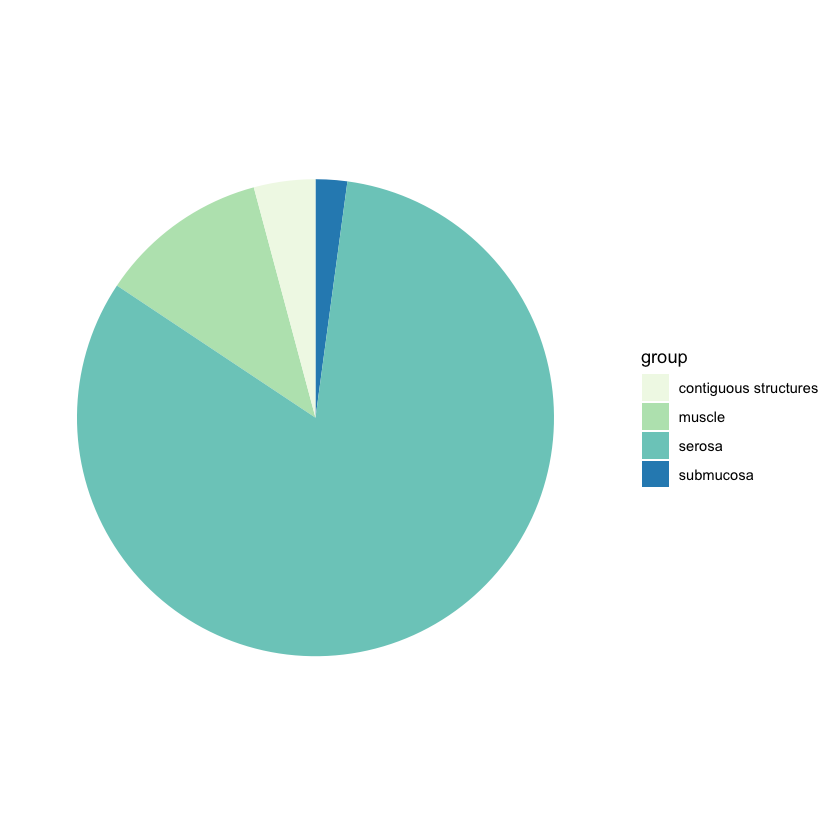

In [8]:
library(scales)
df = data.frame(group = c("submucosa","muscle","serosa","contiguous structures"), value = c(38,204,1460,74),percent = c("2.1%","11.5%","82.2%","4.2%"))
blank_theme <- theme_minimal()+
  theme(
  axis.title.x = element_blank(),
  axis.title.y = element_blank(),
  panel.border = element_blank(),
  panel.grid=element_blank(),
  axis.ticks = element_blank(),
  plot.title=element_text(size=14, face="bold")
  )
bp<- ggplot(df, aes(x="", y=value, fill=group))+
geom_bar(width = 1, stat = "identity")
pie <- bp + coord_polar("y", start=0)
pie + scale_fill_brewer(palette = 4) + blank_theme +
  theme(axis.text.x=element_blank())

knitr::kable(df)

The quantile of recurrence time:

In [9]:
quantile(filter(data,etype == 1)$time,probs = c(seq(0, 1, 0.1)))

0%    10%    20%    30%    40%    50%    60%    70%    80%    90%   100% 
   8.0  173.0  294.8  482.3  734.2 1556.0 2059.4 2200.0 2413.6 2672.6 3329.0

The quantile of death time:

In [11]:
quantile(filter(data,etype == 2)$time,probs = c(seq(0, 1, 0.1)))

0%    10%    20%    30%    40%    50%    60%    70%    80%    90%   100% 
  23.0  410.4  676.2  966.2 1446.8 1983.0 2164.2 2284.0 2485.6 2706.6 3329.0

We could plot the density of the recurrence and death timehere:

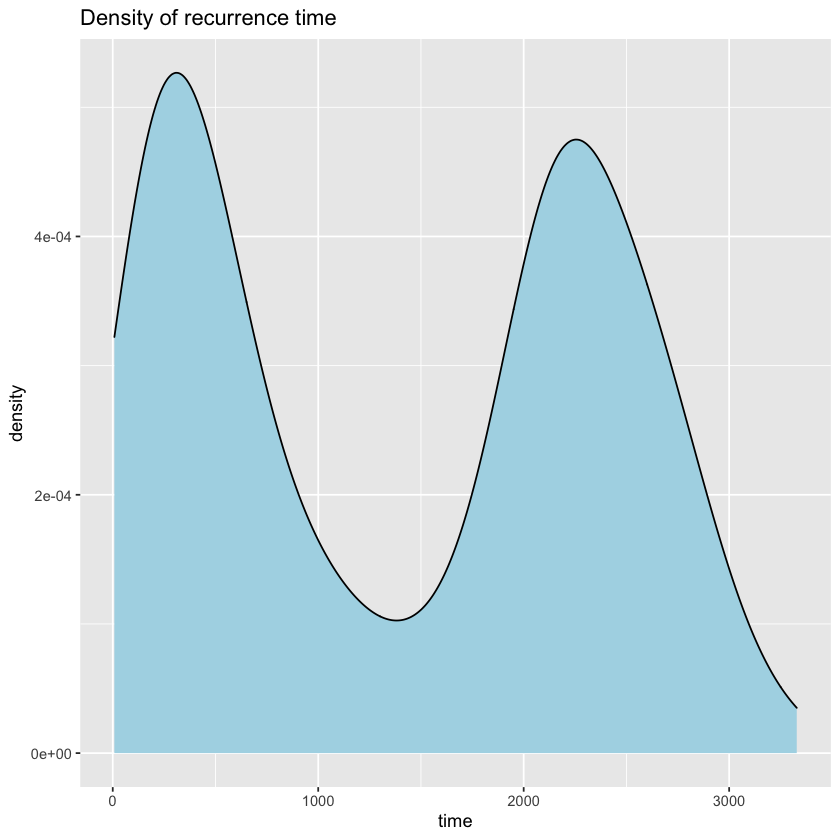

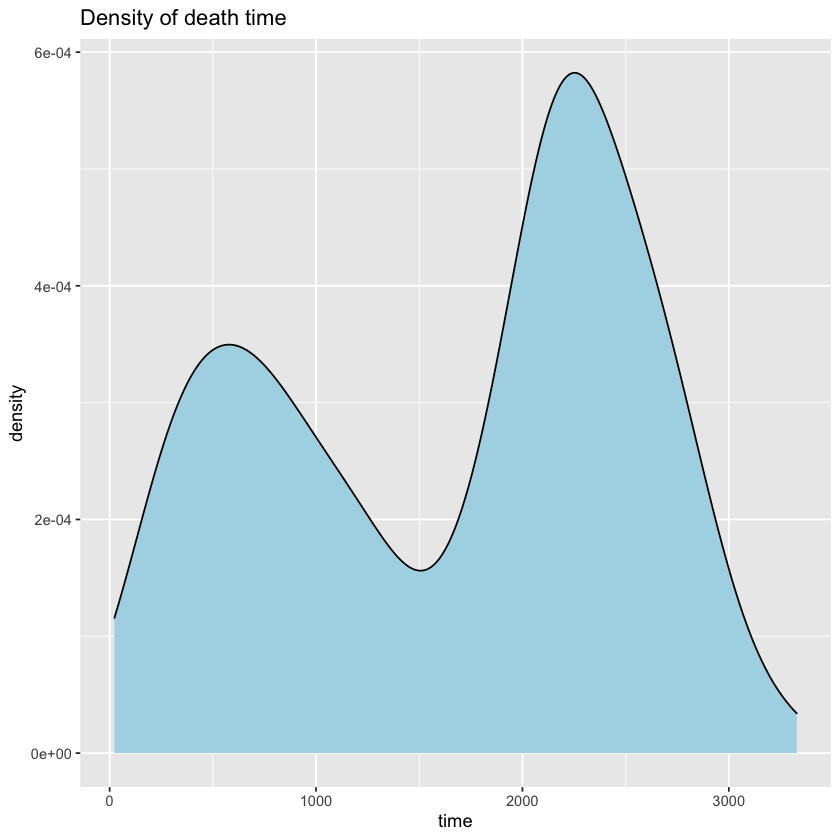

In [12]:
df = filter(data, etype == 1)
ggplot(df, aes(x = time)) + geom_density(fill = "light blue") + ggtitle("Density of recurrence time")
df = filter(data, etype == 2)
ggplot(df, aes(x = time)) + geom_density(fill = "light blue") + ggtitle("Density of death time")

## Kaplan-Meier estimation

In cancer study, there are some frequently asked questions such as:
* What is the probability that an individual survives 3 years?
* Are there differences in survival between groups of patients?
* What is the impact of certain clinical characteristics on patient’s survival

Among all of our tools, the Kaplan-Meier estimations can make plots to visualize survival curves. In the colon dataset, we have some data with censored status. Those data could resulted by:
* a patient has not (yet) experienced the event of interest, such as relapse or death, within the study time period;
* a patient is lost to follow-up during the study period;
* a patient experiences a different event that makes further follow-up impossible.
This type of censoring, named right censoring, is handled in survival analysis and KM-estimation.

The Kaplan-Meier method is a non-parametric method used to estimate the survival probability from observed survival times (Kaplan and Meier, 1958), with the survival probability at time $t_i$, $S(t_i)$, is calculated as:

$$S(t_i)=S(t_i−1)(1−d_in_i)$$

Where $S(t_i−1)$ is the probability of being alive at time $t_{i−1}$, $n_i$ is the number of patients alive just before $t_i$, $d_i$ is the number of events at $t_i$. The estimated KM setimator $S(t)$ is a step function which changes value only at the time of each event. A plot of the KM survival probability against time, provides a useful summary of the data that can be used to estimate measures such as median survival time.

First lets get the KM-estimation for those three treatment group:

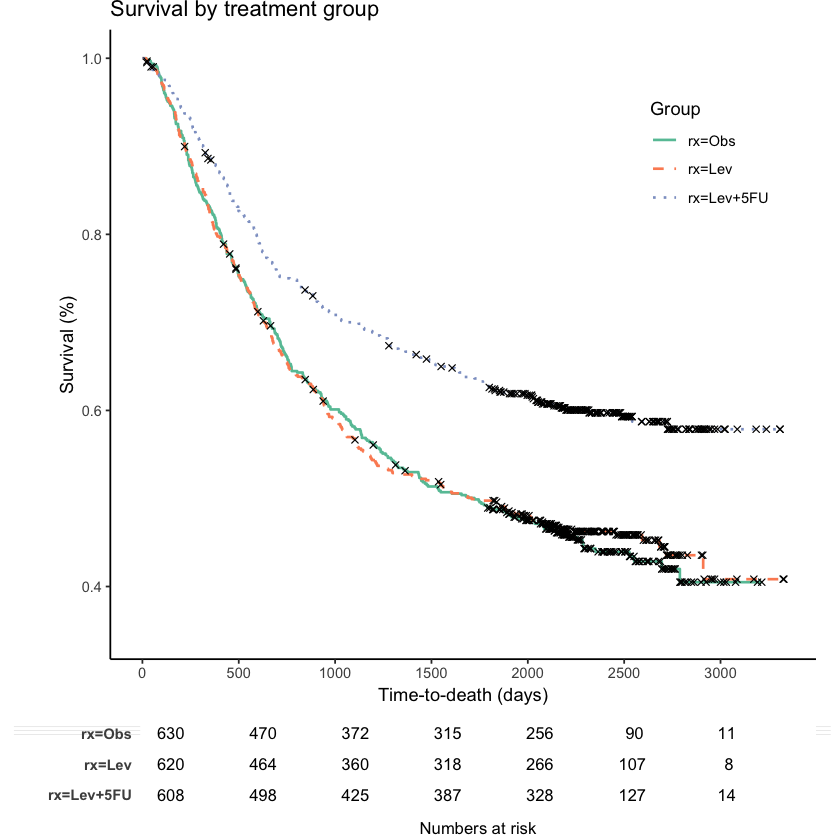

In [13]:
data1 = filter(colon, etype == 2)
library(ggkm)
fit = survfit(Surv(time,status)~rx, data=colon)
ggkm(fit, table = T, ylim = c(0.35,1),
     main="Survival by treatment group", 
     ystrataname = "Group",
     xlabs = "Time-to-death (days)",
     dashed=TRUE,
     shape = 4,
     linecols = "Set2")

We obtained the KM-estimation plot and the risk table here. X stands for censored data in the plot. In this plot, we could clearly observe that the treatment Lev+5FU group has a much better survival rate than other two groups. To make a statistically decision rather than decide by plot, we could use the estimated variance of the KM estimator via the Greenwood formula:
$$var(\hat S_t) = \hat S_t^2 \sum_{t_i<=t} \frac{d_i}{n_i(n_i-d_i)}$$
With this formula, we could obtain the confidence interval of the KM estimator:

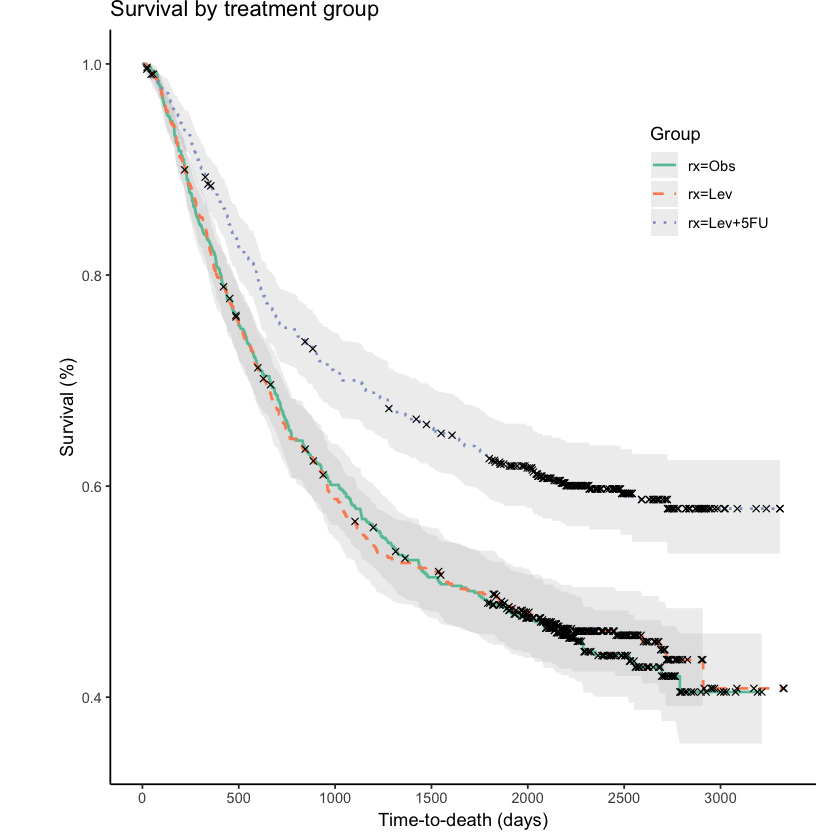

In [15]:
ggkm(fit, table = F, 
     main="Survival by treatment group", 
     ystrataname = "Group",
     xlabs = "Time-to-death (days)",
     dashed=TRUE,
     shape = 4,
     ci = TRUE,
     linecols = "Set2",ylim = c(0.35,1))

With the confidence interval separate apart, we could belive they are different. Furthermore we could use the log-rank test, and obtain the p valus. The null hypothesis is that there is no difference in survival between those groups. It is a non-parametric test, which makes no assumptions about the survival distributions. The log rank statistic is approximately distributed as a chi-square test statistic.

To perform log-rank test, we will use the function *survdiff()* in *survival* package.

In [16]:
surv_diff <- survdiff(Surv(time,status)~rx, data=colon)
surv_diff

Call:
survdiff(formula = Surv(time, status) ~ rx, data = colon)

             N Observed Expected (O-E)^2/E (O-E)^2/V
rx=Obs     630      345      299      7.01     10.40
rx=Lev     620      333      295      4.93      7.26
rx=Lev+5FU 608      242      326     21.61     33.54

 Chisq= 33.6  on 2 degrees of freedom, p= 5e-08 


As the p-value is $5\times 10^{-8}$, we could reject the null hypothesis that the groups have the same survival function.

## KM Estimation for other factor covariates

* Covariate node 4

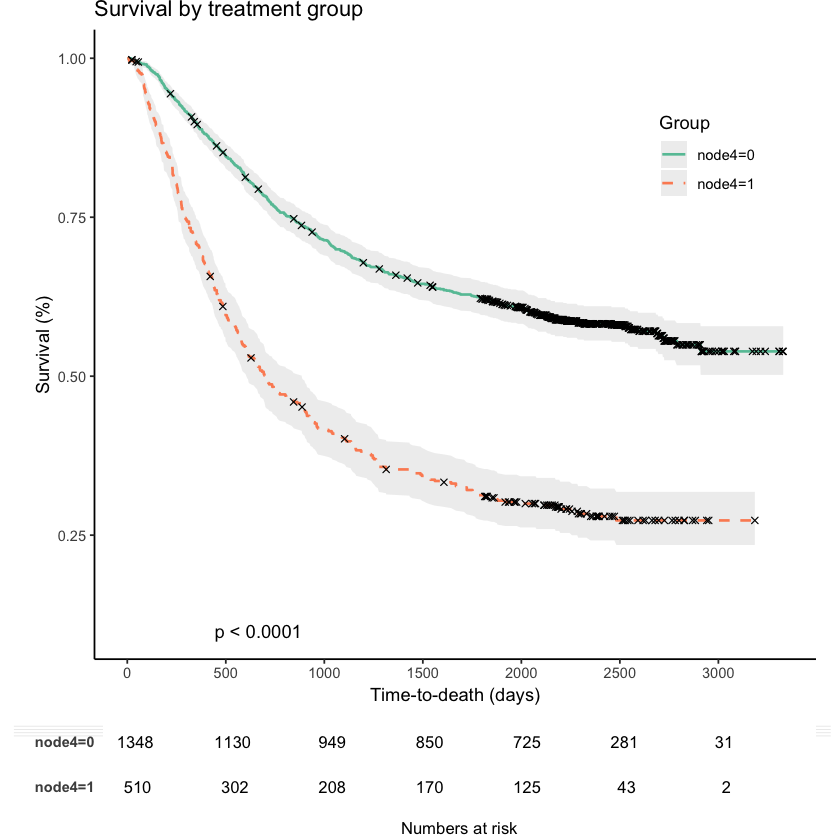

In [17]:
fit = survfit(Surv(time,status)~node4, data=colon)
ggkm(fit, table = T, 
     main="Survival by treatment group", 
     ystrataname = "Group",
     xlabs = "Time-to-death (days)",
     dashed=TRUE,
     shape = 4,
     pval = TRUE,
     ci = TRUE,
     linecols = "Set2",ylim = c(0.1,1))

This covariate seems to be very different with a p value smaller than 0.0001. This covariate serves as a variable to measure the severeness of the cancer, and we could predict the hazard rate use this covariate.

* Covariate sex

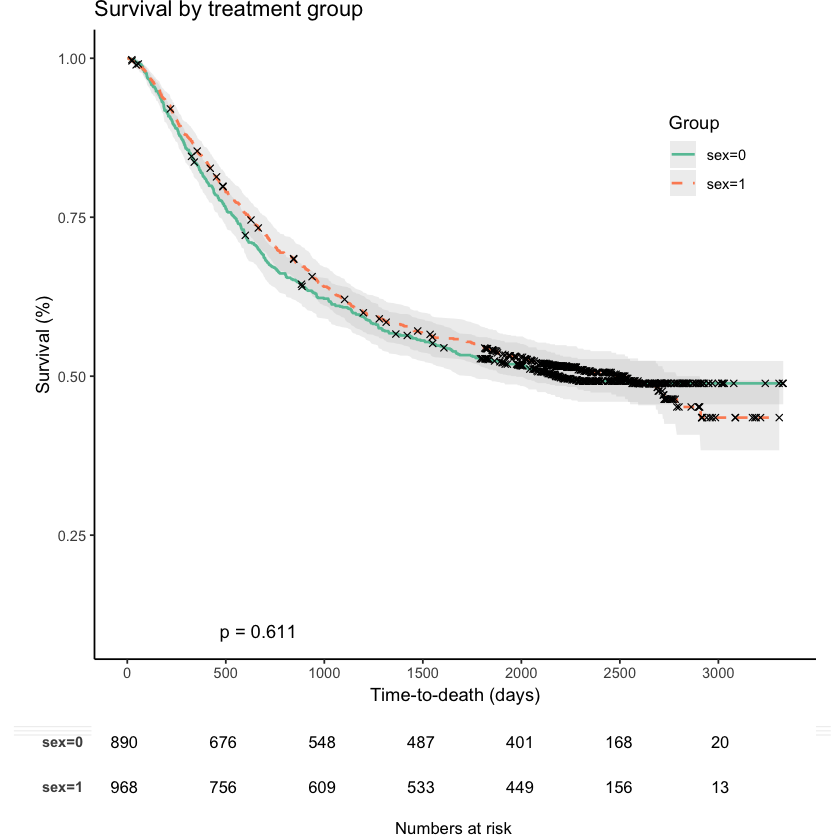

In [18]:
fit = survfit(Surv(time,status)~sex, data=colon)
ggkm(fit, table = T, 
     main="Survival by treatment group", 
     ystrataname = "Group",
     xlabs = "Time-to-death (days)",
     dashed=TRUE,
     shape = 4,
     pval = TRUE,
     ci = TRUE,
     linecols = "Set2",ylim = c(0.1,1))

Both the plot and the log-rank p value suggest that this covariate should not be included in our model. Male and Female patients don't have significantly difference in survival function.

* Covariate obstruction of colon by tumour

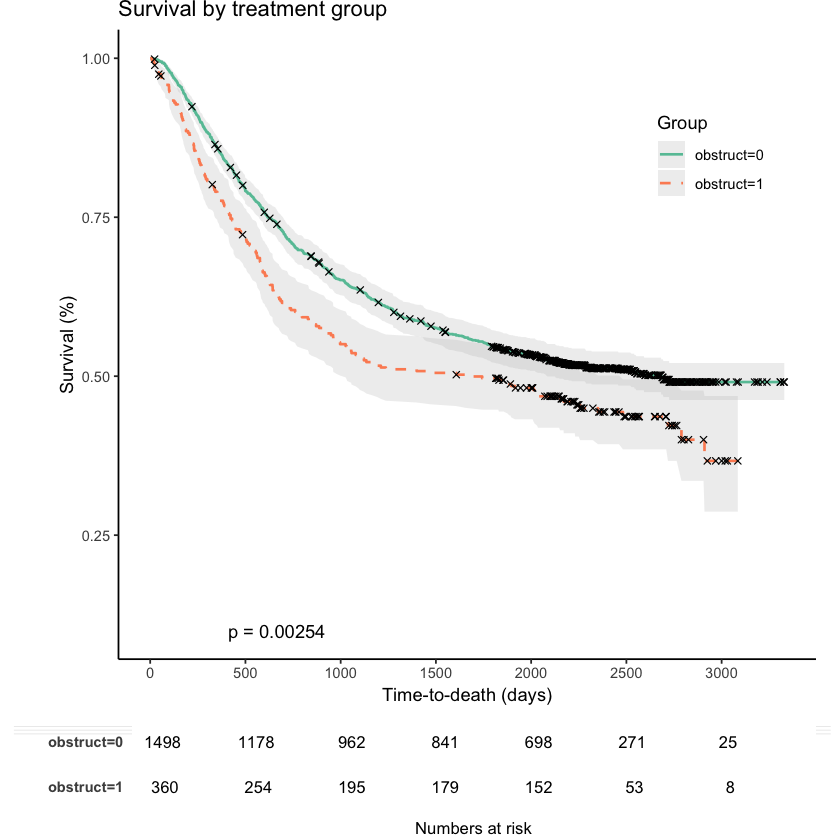

In [19]:
fit = survfit(Surv(time,status)~obstruct, data=colon)
ggkm(fit, table = T, 
     main="Survival by treatment group", 
     ystrataname = "Group",
     xlabs = "Time-to-death (days)",
     dashed=TRUE,
     shape = 4,
     pval = TRUE,
     ci = TRUE,
     linecols = "Set2",ylim = c(0.1,1))

Similiar result with covariate node4, with a bigger but still significant p value.

* Covariate perforation

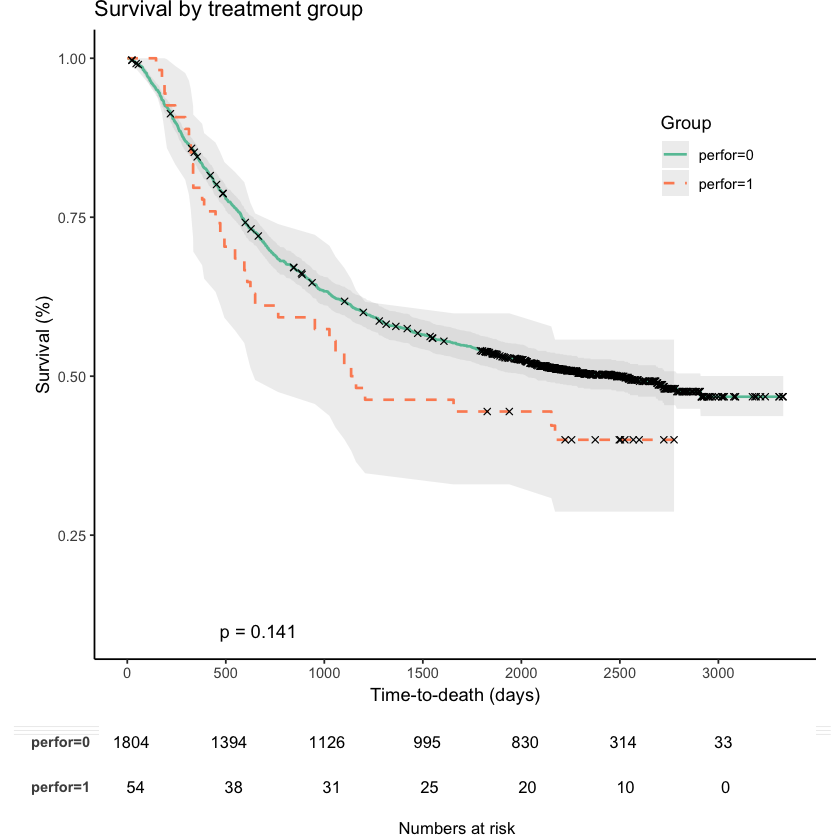

In [20]:
fit = survfit(Surv(time,status)~perfor, data=colon)
ggkm(fit, table = T, 
     main="Survival by treatment group", 
     ystrataname = "Group",
     xlabs = "Time-to-death (days)",
     dashed=TRUE,
     shape = 4,
     pval = TRUE,
     ci = TRUE,
     linecols = "Set2",ylim = c(0.1,1))

From the table we could find that this covariate have much less case in value 1, and the p value is 0.141, we may not use this covariate in our final model.

* Covariate surg

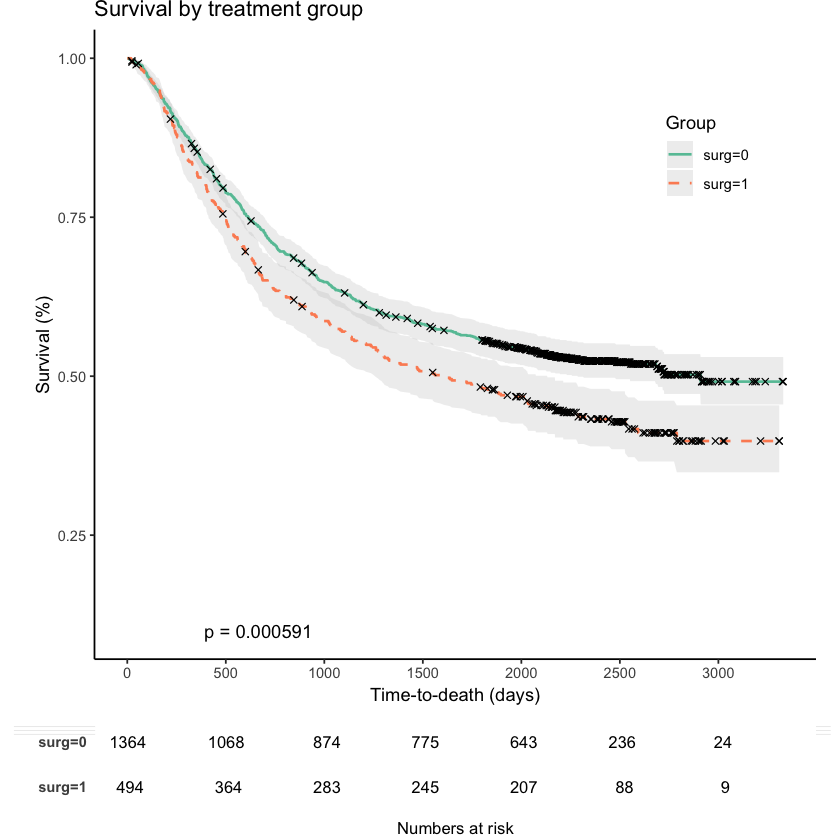

In [21]:
fit = survfit(Surv(time,status)~surg, data=colon)
ggkm(fit, table = T, 
     main="Survival by treatment group", 
     ystrataname = "Group",
     xlabs = "Time-to-death (days)",
     dashed=TRUE,
     shape = 4,
     pval = TRUE,
     ci = TRUE,
     linecols = "Set2",ylim = c(0.1,1))

The plot and the p value indicates that patients recently have a surgery will have higher survival rate than the other group. It is another covariate should be included in the final model, as it should be independent with the covariate node4, as this covariate is about treatment, not the health condition.

* Covariate extent

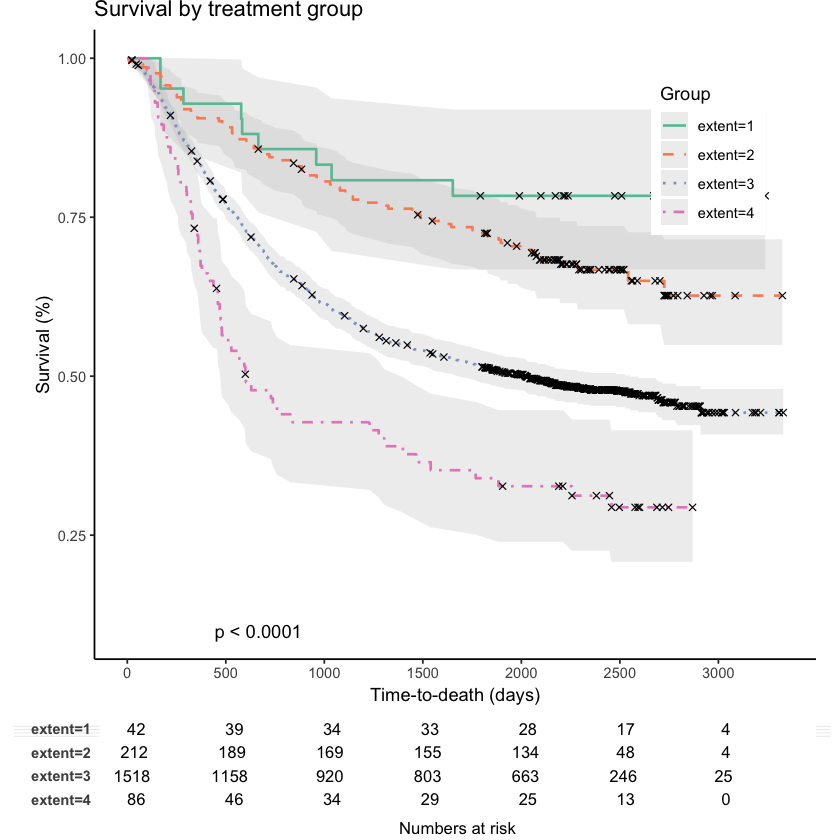

In [22]:
fit = survfit(Surv(time,status)~extent, data=colon)
ggkm(fit, table = T, 
     main="Survival by treatment group", 
     ystrataname = "Group",
     xlabs = "Time-to-death (days)",
     dashed=TRUE,
     shape = 4,
     pval = TRUE,
     ci = TRUE,
     linecols = "Set2",ylim = c(0.1,1))

With the plot and p value smaller than 0.0001, we could say this covariate is significant for difference of the survival functions. Furthermore, this covariate is another health condition indicator for patients. This is similiar for covariate differ and adhere:

* Covariate adhere

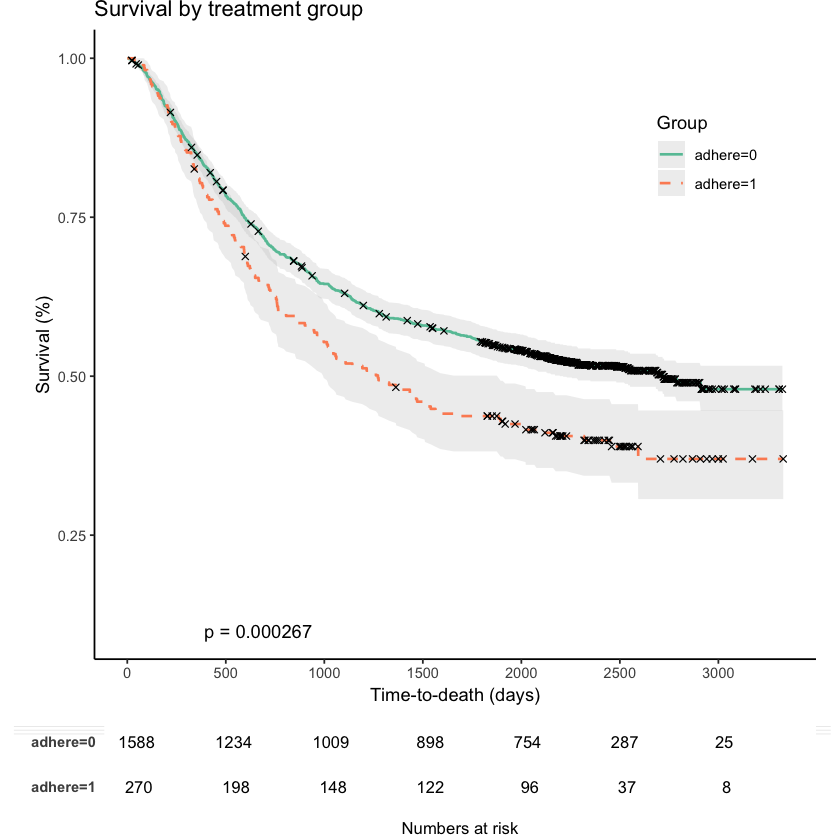

In [23]:
fit = survfit(Surv(time,status)~adhere, data=colon)
ggkm(fit, table = T, 
     main="Survival by treatment group", 
     ystrataname = "Group",
     xlabs = "Time-to-death (days)",
     dashed=TRUE,
     shape = 4,
     pval = TRUE,
     ci = TRUE,
     linecols = "Set2",ylim = c(0.1,1))

* Covariate differ

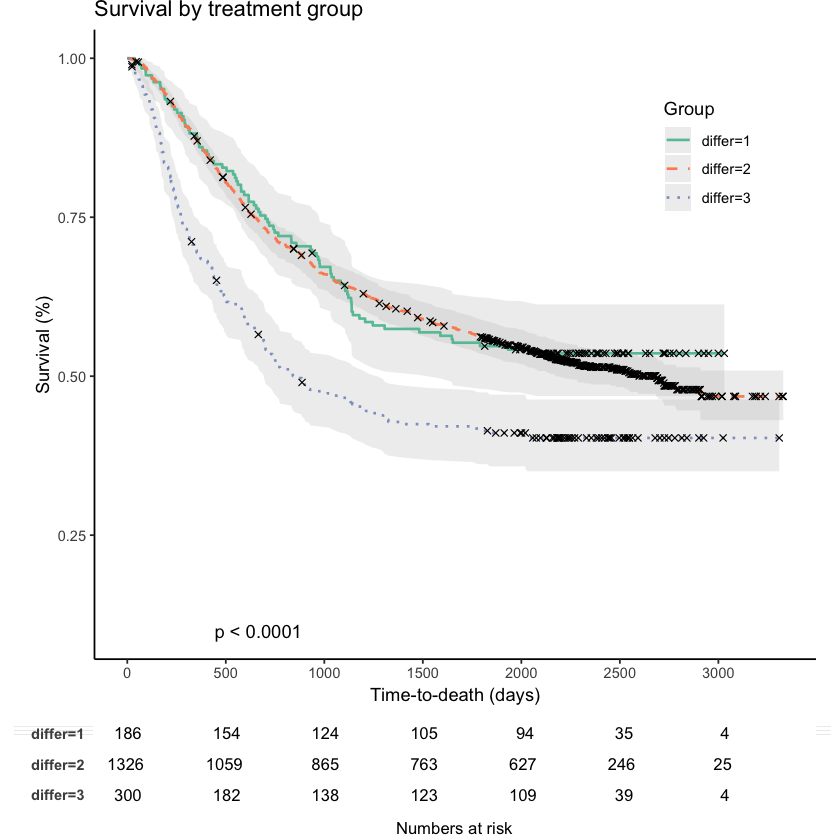

In [25]:
fit = survfit(Surv(time,status)~differ, data=colon)
ggkm(fit, table = T, 
     main="Survival by treatment group", 
     ystrataname = "Group",
     xlabs = "Time-to-death (days)",
     dashed=TRUE,
     shape = 4,
     pval = TRUE,
     ci = TRUE,
     linecols = "Set2",ylim = c(0.1,1))

## Cox Proportional Hazard Model

Next we build a time-independent cox proportional hazard model, and select the best model. We will also diagnose the model and check some other assumptions.

## The Full Cox Model 

First we build a full cox model:

In [26]:
data$status = as.numeric(data$status)
fullmodel = coxph(formula = Surv(time, status) ~ rx + age + obstruct + perfor + adhere + differ + extent + surg + node4 , data = data)
summary(fullmodel)

Call:
coxph(formula = Surv(time, status) ~ rx + age + obstruct + perfor + 
    adhere + differ + extent + surg + node4, data = data)

  n= 1776, number of events= 876 

               coef exp(coef)  se(coef)      z Pr(>|z|)    
rxLev     -0.019585  0.980606  0.079354 -0.247  0.80506    
rxLev+5FU -0.419514  0.657366  0.086096 -4.873 1.10e-06 ***
age        0.002382  1.002385  0.002931  0.813  0.41638    
obstruct   0.216948  1.242280  0.084581  2.565  0.01032 *  
perfor     0.120639  1.128218  0.185352  0.651  0.51513    
adhere     0.173005  1.188872  0.092370  1.873  0.06107 .  
differ     0.153360  1.165744  0.069629  2.203  0.02763 *  
extent     0.469842  1.599742  0.084145  5.584 2.35e-08 ***
surg1      0.228341  1.256514  0.074139  3.080  0.00207 ** 
node41     0.873752  2.395883  0.071157 12.279  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
rxLev        0.9806     1.0198    0.8394    1.1456
r

The summary shows the model is significant in likelihood ratio test, which means the null hypothesis, all of the coefficients are 1 is rejected. But some of the variable may be not so informatic. Then we will select a better model.

First we use backward AIC criterion to remove some redundant variable:

In [27]:
model1 = step(fullmodel,direction="backward")

Start:  AIC=12269.18
Surv(time, status) ~ rx + age + obstruct + perfor + adhere + 
    differ + extent + surg + node4

           Df   AIC
- perfor    1 12268
- age       1 12268
<none>        12269
- adhere    1 12271
- differ    1 12272
- obstruct  1 12274
- surg      1 12276
- rx        2 12295
- extent    1 12301
- node4     1 12405

Step:  AIC=12267.59
Surv(time, status) ~ rx + age + obstruct + adhere + differ + 
    extent + surg + node4

           Df   AIC
- age       1 12266
<none>        12268
- adhere    1 12270
- differ    1 12270
- obstruct  1 12272
- surg      1 12275
- rx        2 12294
- extent    1 12300
- node4     1 12403

Step:  AIC=12266.18
Surv(time, status) ~ rx + obstruct + adhere + differ + extent + 
    surg + node4

           Df   AIC
<none>        12266
- adhere    1 12268
- differ    1 12269
- obstruct  1 12271
- surg      1 12274
- rx        2 12292
- extent    1 12298
- node4     1 12402


From the AIC procedure, we select a model with variable rx, obstruct, adhere, differ, extent ,surg and node4. The variable age, perforation are dropped, which is coincidence with our KM estimation analysis in the previous part.

## Scaled Schoenfeld residuals plots

Then we need to check the cox proportional hazard assumption for the variables. We will use the scaled Schoenfeld residuals plot to check the proportional hazard assumption. The solid line is the smoothing function, and the broken lines are the confidence interval for that estimation. If the assumption of proportional hazards is true, then the solid line should be horizon.

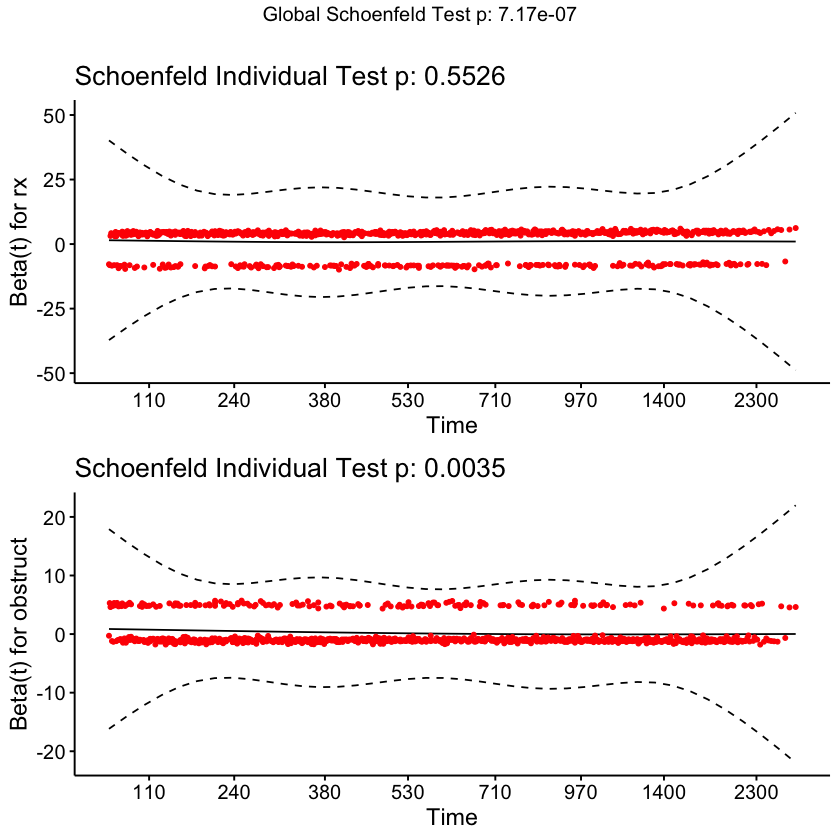

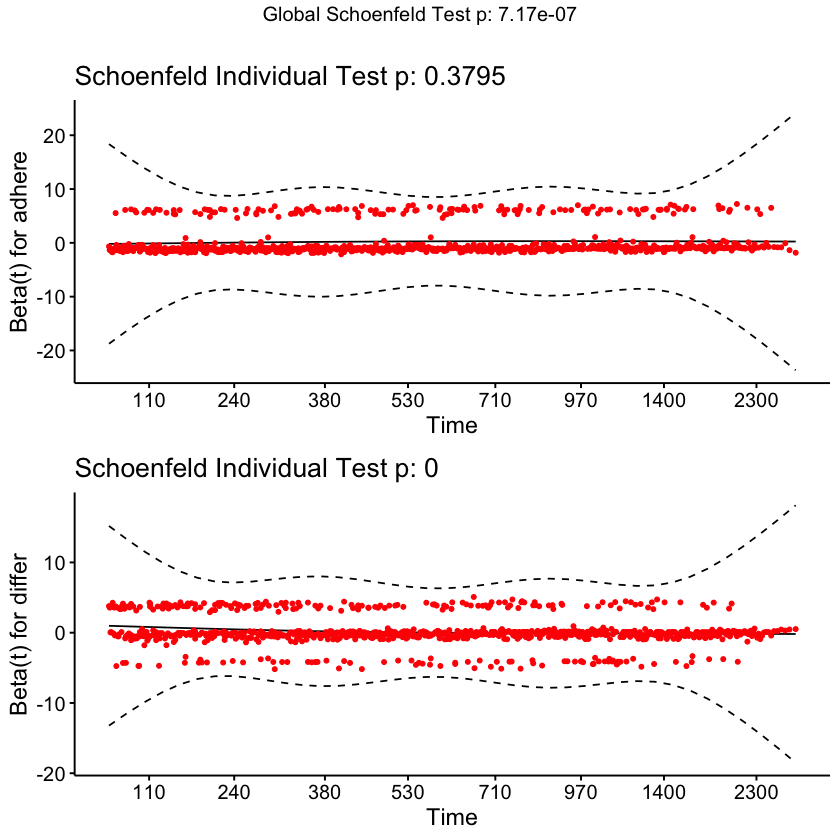

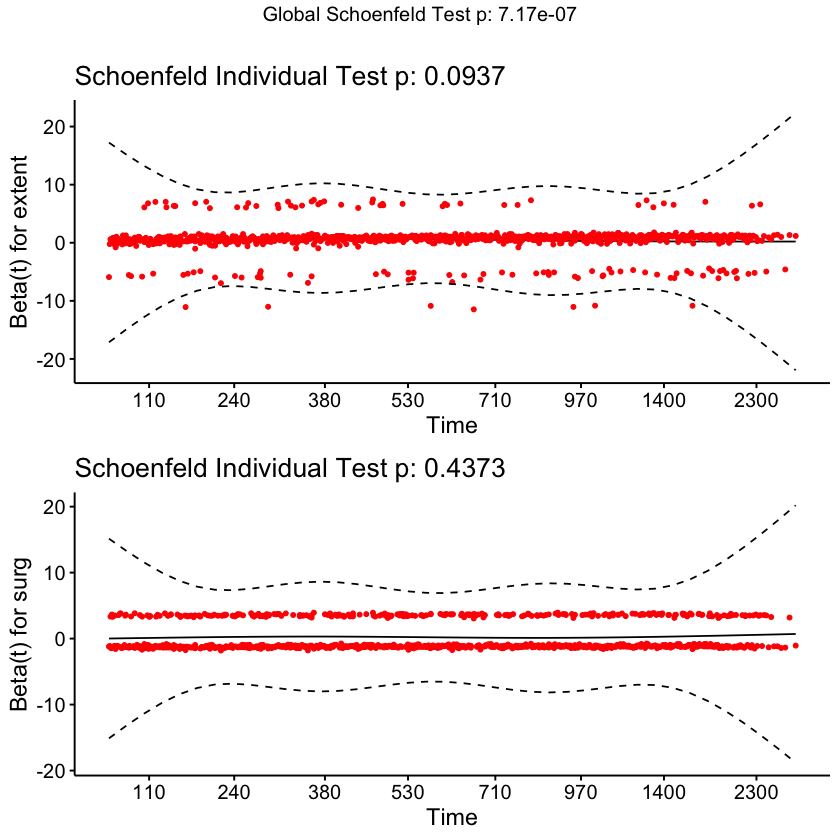

          chisq df       p
rx        1.186  2  0.5526
obstruct  8.549  1  0.0035
adhere    0.772  1  0.3795
differ   20.030  1 7.6e-06
extent    2.810  1  0.0937
surg      0.603  1  0.4373
node4     9.847  1  0.0017
GLOBAL   43.468  8 7.2e-07

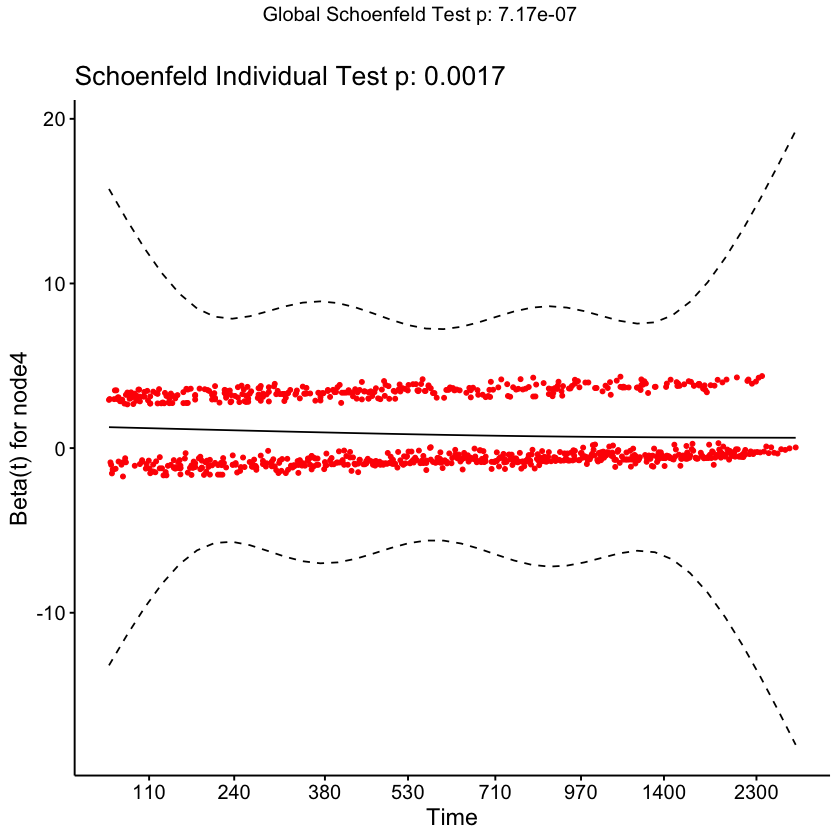

In [28]:
library(survminer)
z1=cox.zph(model1)
ggcoxzph(z1, var = colnames(z1$y)[1:2])
ggcoxzph(z1, var = colnames(z1$y)[3:4])
ggcoxzph(z1, var = colnames(z1$y)[5:6])
ggcoxzph(z1, var = colnames(z1$y)[7])
z1

With a power of 0.05, the covariate obstruct, differ, and node4 reject the null hypothesis, which indicate they don't meet the proportional hazard assumption. We could refer the KM-estimator of the covariate differ and obstruct, and find that their KM-estimator is clearly non-proportional. In this case, we need use stratication for those variables. Though stratifications will make us unable to determine the coefficient of that covariate, as we have already determine the influence via KM-estimation, that is not a problem.

In [29]:
model2 = coxph(formula = Surv(time, status) ~ rx + strata(obstruct)+ adhere + strata(differ) + extent + surg + strata(node4) , data = data)
cox.zph(model2)

               chisq df    p
rx              1.39  2 0.50
adhere          2.45  1 0.12
strata(differ)  1.09  1 0.30
extent          0.83  1 0.36
GLOBAL          6.08  5 0.30

Now our model seems to not violate the proportional hazard assumption.

## Hazard ratios and its C.I

Next we will interpret our model and find the confidence interval of the hazard ratio:

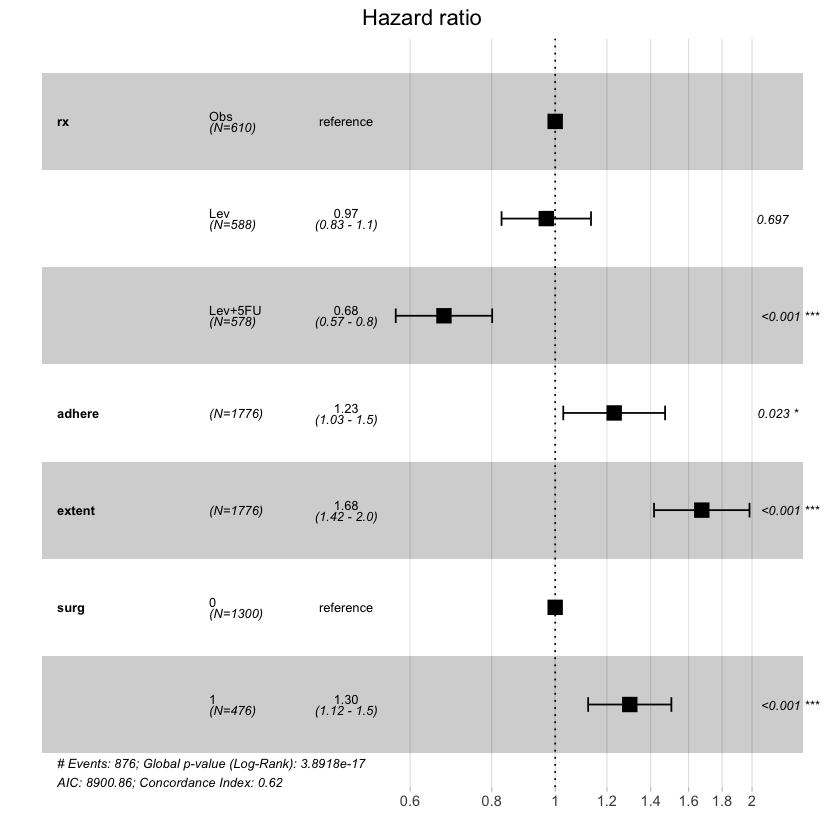

In [30]:
model2 = coxph(formula = Surv(time, status) ~ rx + strata(obstruct)+ adhere + strata(differ) + extent + surg + strata(node4) , data = data)
attr(model2$terms,"dataClasses") = attr(model2$terms,"dataClasses")[c(-3,-5,-8)]
ggforest(model2,data = data)

From this result, we could find that the treatment Lev+5FU has a 0.68 hazard ratio with 95% CI 0.57-0.8, which is sufficient to illustrate that this treatment is efficient for colon cancer. For other covariates, the adhere and extent are health condition indicators, with higher values indicates worse health condition, thus it should have higher hazard ratio coefficient. The surg covariate 1 also have a higher hazard ratio coefficient, because we know that wihout any surgery of the cancer, it will be worse.

## Baseline Hazard Rates 

Here we obtain the base line hazard rates for all of the stratas. The last strata is node4.

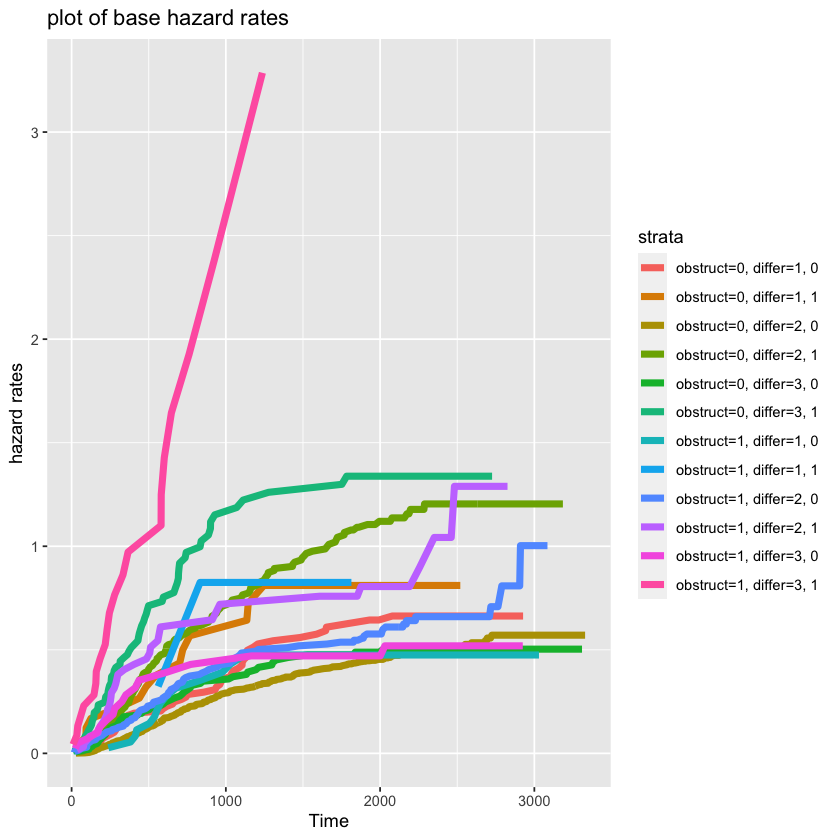

In [31]:
df = basehaz(model2)
ggplot(df, aes(x = time, y = hazard, color = strata)) + geom_line(size = 2)+ labs(title = "plot of base hazard rates", x = "Time", y = "hazard rates")

From the plot, we can see that the group obstruct=1 (obstruction), differ=3 (poor differentiation), node4=1 (more than 4 positive lymph nodes) has a extremely high hazard rate. To compare single covariates, we could reassign colors:

* Covariate node4

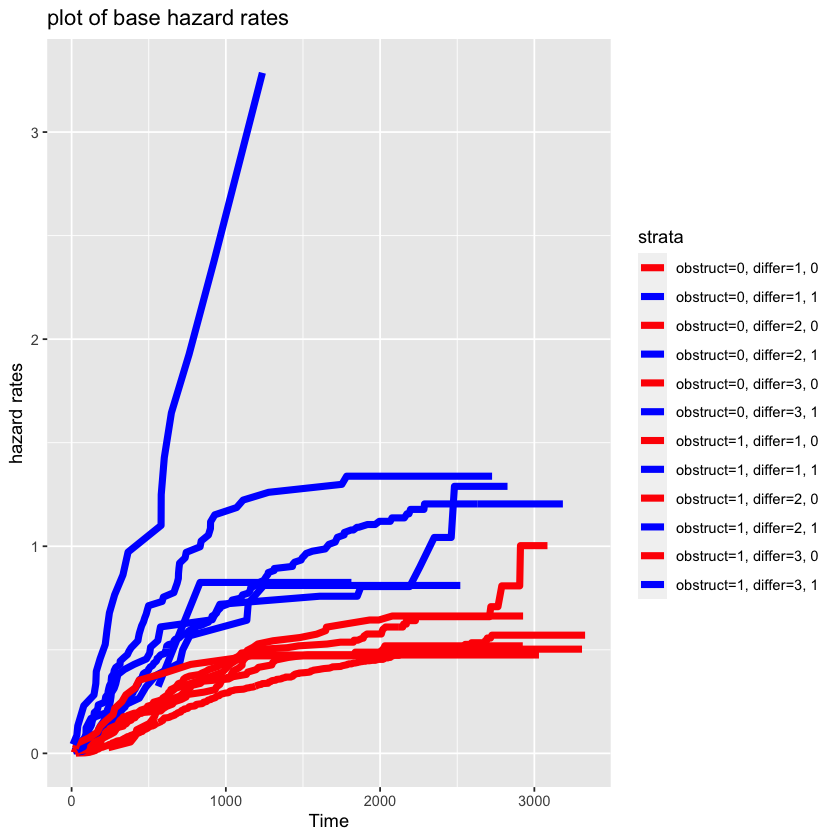

In [32]:
ggplot(df, aes(x = time, y = hazard, color = strata)) + geom_line(size = 2)+ labs(title = "plot of base hazard rates", x = "Time", y = "hazard rates") + scale_color_manual(values=rep(c("red", "blue"),6))

Here we could see node4 is clearly increasing the hazard rate.

* Covariate differ

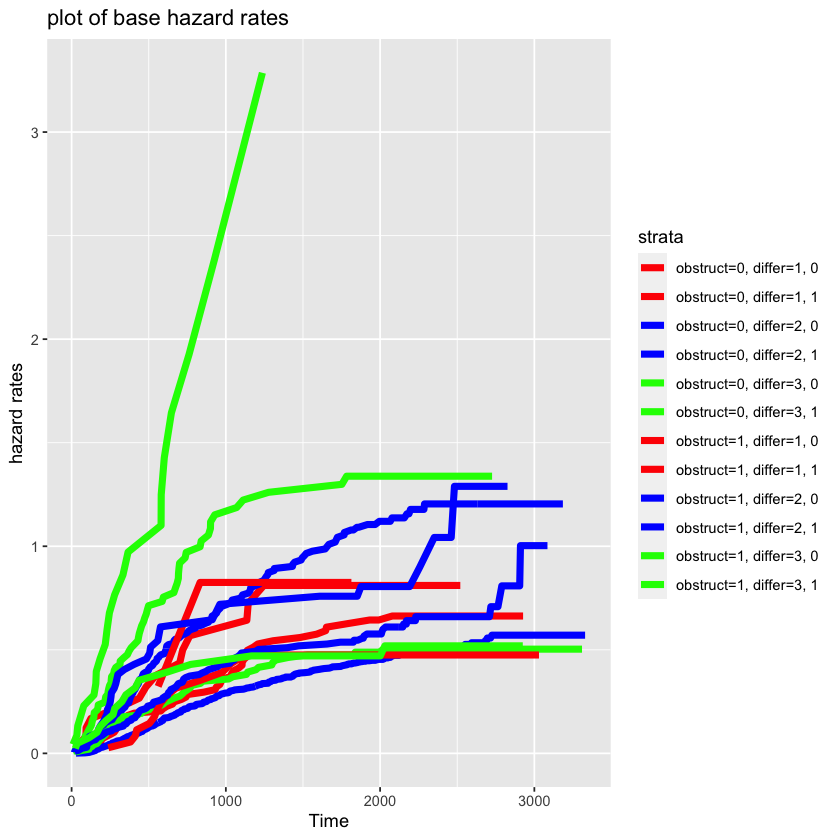

In [33]:
ggplot(df, aes(x = time, y = hazard, color = strata)) + geom_line(size = 2)+ labs(title = "plot of base hazard rates", x = "Time", y = "hazard rates") + scale_color_manual(values=rep(c("red","red", "blue","blue","Green","Green"),2))

Here we could see the covariate differ is not so obvious, but in some of the worst groups, differ must play a important role in it.

* Covariate obstruct

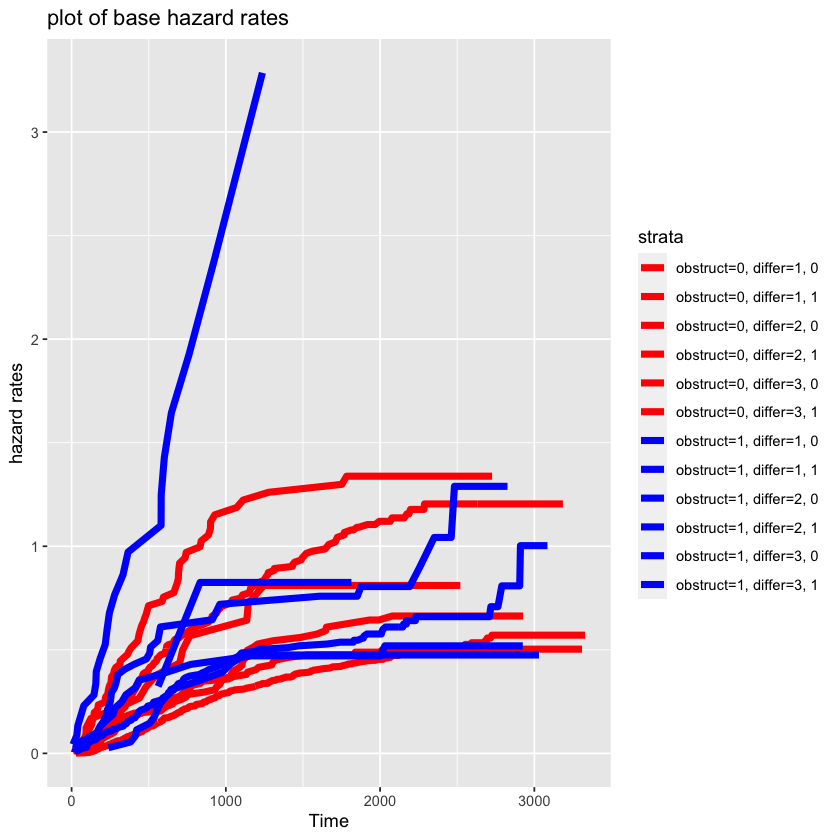

In [34]:

ggplot(df, aes(x = time, y = hazard, color = strata)) + geom_line(size = 2)+ labs(title = "plot of base hazard rates", x = "Time", y = "hazard rates") + scale_color_manual(values=c(rep("red",6),rep("blue",6)))

Obstruct is not so obvious too.
So as a conclusion, the most important strata variable is node4, which will clearly part all of the hazard functions into two groups. Still the covariate obstruct and differ play an important role in different hazard functions.

## AFT Model

The accelerated failure time model is, like a generalized linear model (GLM), an extension of the standard linear model that accounts for specific types of data and non-linearity. AFT models are specified as
$$log(T)=x\beta +\sigma W$$
W has a distribution, which include "weibull", "exponential", "gaussian", "logistic". Themodels are fit using the *survreg()* function, and we will calculate AIC score to select the best model:

In [35]:
weibull <- survreg(Surv(time,status)~rx + obstruct+ adhere + differ + extent + surg + node4,data=data,na.action=na.omit, dist="weibull")
exponential <- survreg(Surv(time,status)~rx + obstruct+ adhere + differ + extent + surg + node4,data=data,na.action=na.omit, dist="exponential")
gaussian <- survreg(Surv(time,status)~rx + obstruct+ adhere + differ + extent + surg + node4,data=data,na.action=na.omit, dist="gaussian")
logistic <- survreg(Surv(time,status)~rx + obstruct+ adhere + differ + extent + surg + node4,data=data,na.action=na.omit, dist="logistic")

T1 = anova(weibull,exponential,gaussian,logistic)[,3]
names(T1) = c("weibull", "exponential", "gaussian", "logistic")
knitr::kable(t(T1))



|  weibull| exponential| gaussian| logistic|
|--------:|-----------:|--------:|--------:|
| 15523.51|    15555.52| 16528.29| 16604.96|

Because the Weibull model has the smallest AIC, we will use Weibull model:

* Weibull model

In [36]:
WeibullReg <- survreg(Surv(time,status)~rx + obstruct+ adhere + differ + extent + surg + node4,data=data,na.action=na.omit, dist="weibull")
summary(WeibullReg)


Call:
survreg(formula = Surv(time, status) ~ rx + obstruct + adhere + 
    differ + extent + surg + node4, data = data, na.action = na.omit, 
    dist = "weibull")
              Value Std. Error      z       p
(Intercept) 10.4130     0.3376  30.85 < 2e-16
rxLev        0.0335     0.0933   0.36  0.7198
rxLev+5FU    0.5289     0.1016   5.20 2.0e-07
obstruct    -0.2426     0.0984  -2.47  0.0137
adhere      -0.2435     0.1070  -2.28  0.0228
differ      -0.1763     0.0819  -2.15  0.0313
extent      -0.5613     0.0989  -5.68 1.4e-08
surg1       -0.2760     0.0874  -3.16  0.0016
node41      -1.0642     0.0856 -12.44 < 2e-16
Log(scale)   0.1627     0.0297   5.47 4.5e-08

Scale= 1.18 

Weibull distribution
Loglik(model)= -7761.8   Loglik(intercept only)= -7895.9
	Chisq= 268.29 on 8 degrees of freedom, p= 2.3e-53 
Number of Newton-Raphson Iterations: 5 
n= 1776 


## Residuals

To check whether our AFT model fits the observed data well, we can use the residuals of the model. However, because the residuals are calculated based on the observed event times, they will also be censored. Hence we need to use the Kaplan-Meier estimator of the residuals.

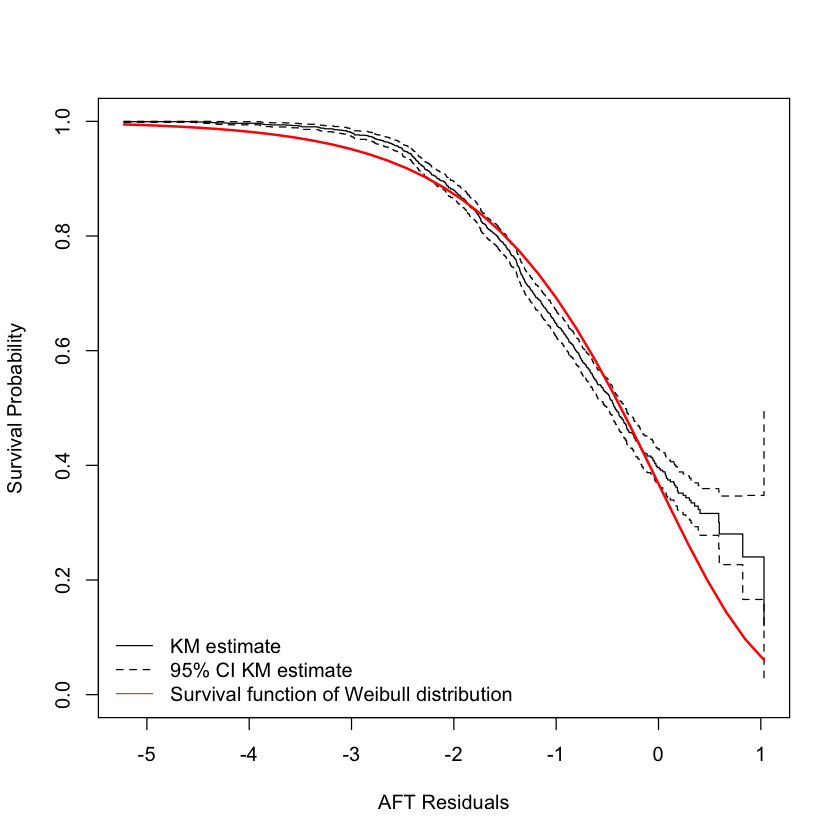

In [37]:
fitted_values <- WeibullReg$linear.predictors
resids <- (log(WeibullReg$y[, 1]) - fitted_values) / WeibullReg$scale
resKM <- survfit(Surv(resids, status) ~ 1, data = data)
plot(resKM, mark.time = FALSE, xlab = "AFT Residuals", ylab = "Survival Probability")
xx <- seq(min(resids), max(resids), length.out = 35)
yy <- exp(- exp(xx))
lines(xx, yy, col = "red", lwd = 2)
legend("bottomleft", c("KM estimate", "95% CI KM estimate", 
    "Survival function of Weibull distribution"), 
    lty = c(1,2,1), col = c(1,1,2), bty = "n")

From this plot we could find the AFT model, though not perfect, but fit the KM estimator good.

## Survival Random Forests

An alternative to building a single survival tree is to build many survival trees, where each tree is constructed using a sample of the data, and average the trees to predict survival. 

A Random Forest is grown by bagging a collection of classification and regression trees (CART). This method uses a set of B bootstrap samples, growing an independent tree model on each sub-sample of the population. Each tree is grown by recursively partitioning the population based on optimization of a split rule over the p-dimensional covariate space. At each split, a subset of $m \leq p$ candidate variables are tested for the split rule optimization, dividing each node into two daughter nodes. Each daughter node is then split again until the process reaches the stopping criteria.

Random forest sorts each training set observation into one unique terminal node per tree. Tree estimates for each observation are constructed at each terminal node, among the terminal node members. The Random Forest estimate for each observation is then calculated by aggregating,
and averaging the terminal node results across the collection of B trees.

A forest of survival trees is grown using a log-rank splitting rule to select the optimal candidate variables. Survival estimate for each observation are constructed with a Kaplan–Meier (KM) estimator within each terminal node, at each event time. Random Survival Forests adaptively discover nonlinear effects and interactions and are fully nonparametric. Averaging over many trees enables it to approximate complex survival functions, including non-proportional hazards, while maintaining low prediction error. 

In [ ]:
library(randomForestSRC)
library(ggRandomForests)
pbc.obj <- rfsrc(Surv(time, status) ~ ., colon,nsplit = 10, na.action = "na.impute",tree.err = TRUE,importance = TRUE)
print(pbc.obj)
Group1 = gg_rfsrc(pbc.obj, by = "node4")
Group2 = gg_rfsrc(pbc.obj, by = "differ")
Group3 = gg_rfsrc(pbc.obj, by = "obstruct")
Group4 = gg_rfsrc(pbc.obj, by = "adhere")
Group5 = gg_rfsrc(pbc.obj, by = "extent")


                         Sample size: 1858
                    Number of deaths: 920
                    Was data imputed: yes
                     Number of trees: 1000
           Forest terminal node size: 15
       Average no. of terminal nodes: 88.953
No. of variables tried at each split: 4
              Total no. of variables: 14
       Resampling used to grow trees: swor
    Resample size used to grow trees: 1174
                            Analysis: RSF
                              Family: surv
                      Splitting rule: logrank *random*
       Number of random split points: 10
                          Error rate: 28.64%



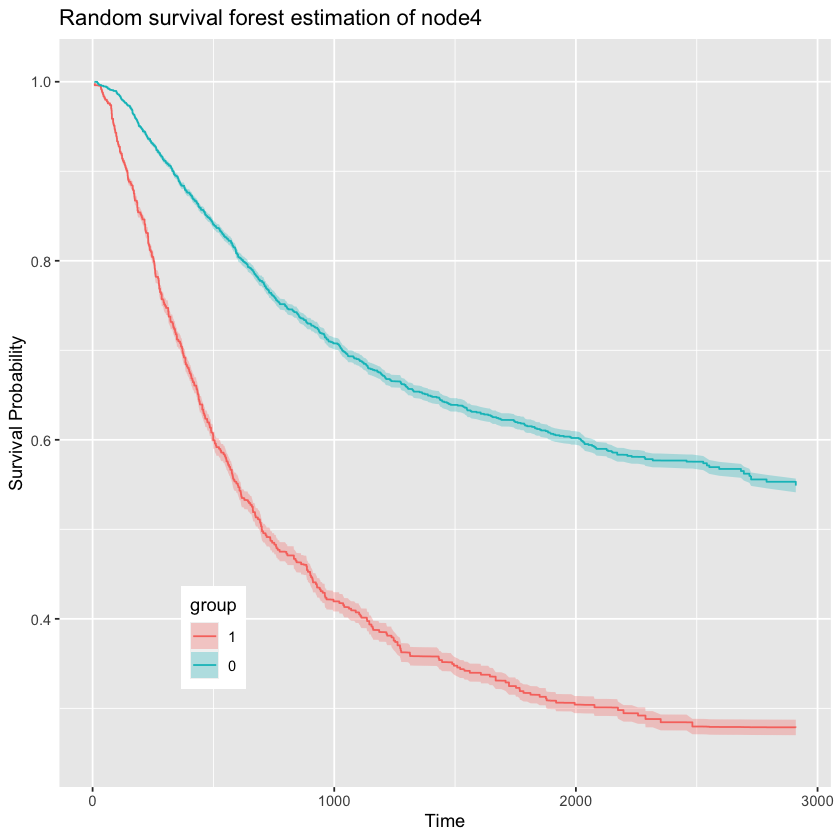

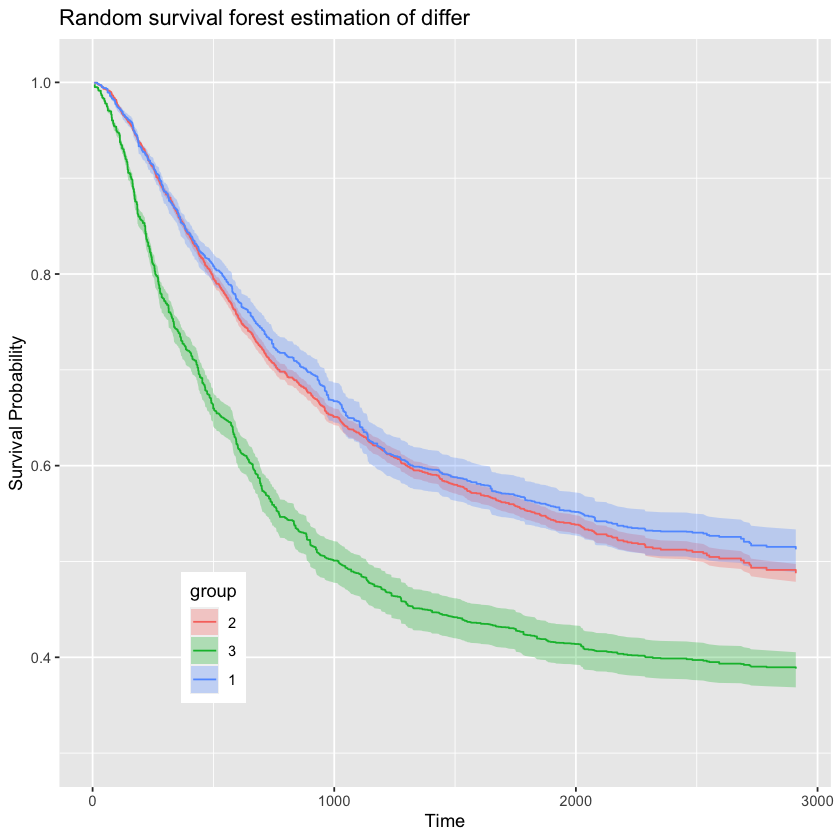

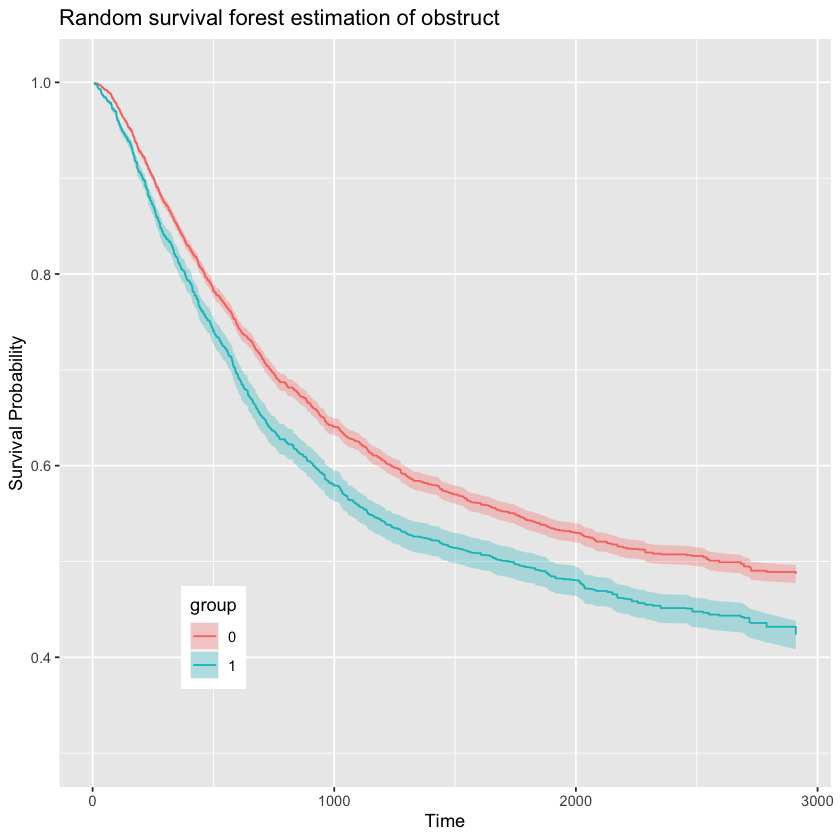

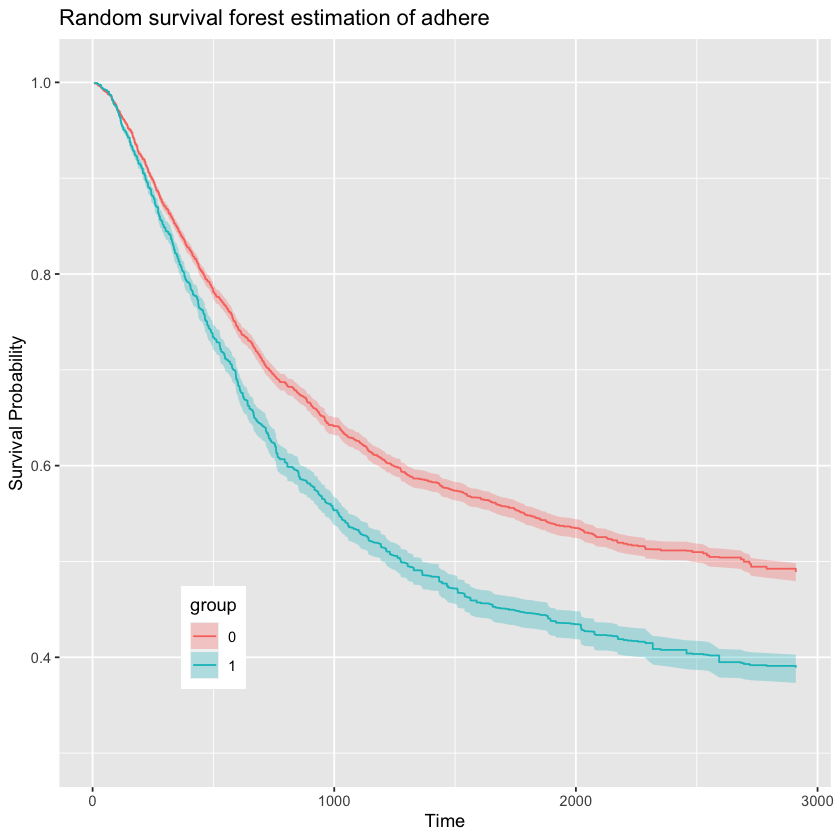

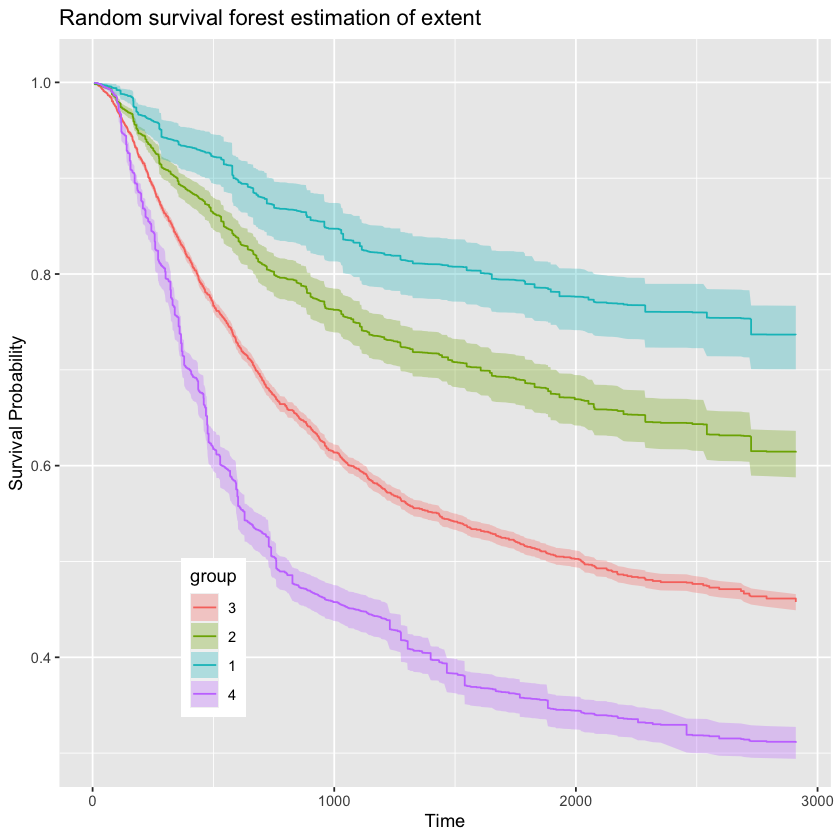

In [39]:
plot(Group1) + theme(legend.position = c(0.2, 0.2)) +labs(y = "Survival Probability", x = "Time") + coord_cartesian(ylim = c(0.25, 1.01)) + ggtitle("Random survival forest estimation of node4")
plot(Group2) + theme(legend.position = c(0.2, 0.2)) +labs(y = "Survival Probability", x = "Time") + coord_cartesian(ylim = c(0.30, 1.01)) + ggtitle( "Random survival forest estimation of differ")
plot(Group3) + theme(legend.position = c(0.2, 0.2)) +labs(y = "Survival Probability", x = "Time") + coord_cartesian(ylim = c(0.30, 1.01)) + ggtitle( "Random survival forest estimation of obstruct")
plot(Group4) + theme(legend.position = c(0.2, 0.2)) +labs(y = "Survival Probability", x = "Time") + coord_cartesian(ylim = c(0.30, 1.01)) + ggtitle( "Random survival forest estimation of adhere")
plot(Group5) + theme(legend.position = c(0.2, 0.2)) +labs(y = "Survival Probability", x = "Time") + coord_cartesian(ylim = c(0.30, 1.01)) + ggtitle( "Random survival forest estimation of extent")

From these plots we could find the random forest method have a similar result with the KM-estimator and the cox model. Moreover, the random forest method get a good estimation of group differ, in that picture you can see the group differ = 1 and the group differ = 2 have intersected survival curve, which means the random forest method estimated the non-proportional hazard function. 

## Variable Importance 

Variable importance (VIMP) was originally defined in CART using a measure involving surrogate variables. VIMP value indicates that misspecification detracts from the predictive accuracy in the forest. VIMP close to zero indicates the variable contributes nothing to predictive accuracy, and negative values indicate the predictive accuracy improves when the variable is misspecified. 

The following picture shows the VIMP scores for all of the variables.

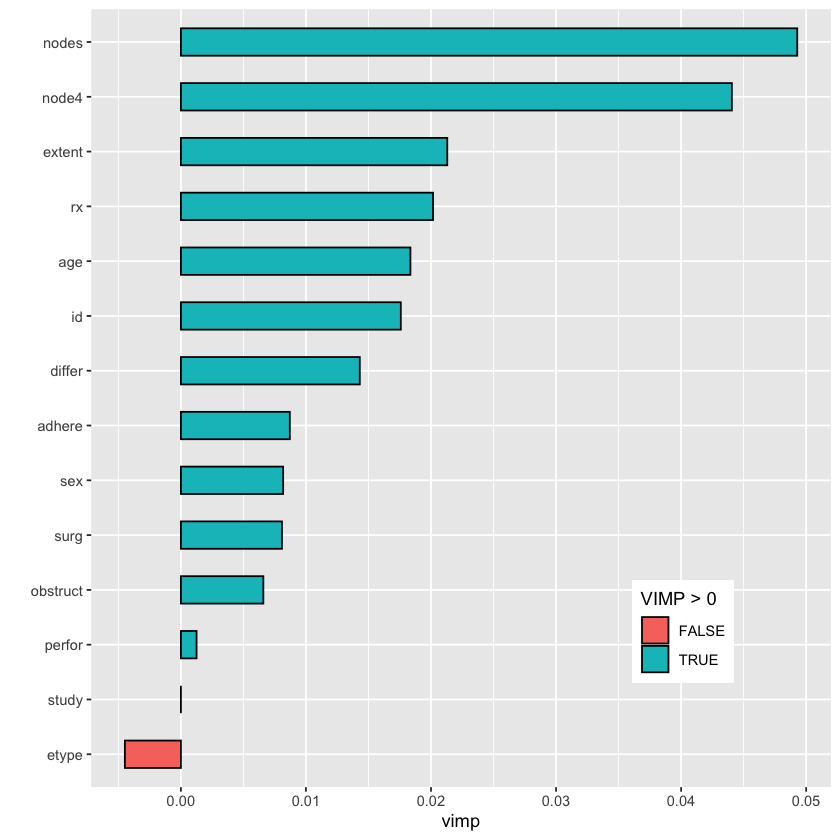

In [43]:
plot(gg_vimp(pbc.obj)) + theme(legend.position = c(0.8, 0.2)) + labs(fill = "VIMP > 0")

## Conclusion and Reflection

In this project, We analyzed the colon data, found that the treatment Lev+5FU do have a significant effect on survival rate. We plotted Kaplan-Meier curve whether different groups have different survival curve. We used log-rank test prove some variable have significant effect. To fit the cox proportional hazard model, we use AIC criterion to select appropriate model, and then check the proportional assumption. Then we use stratifictaion model for those variables don't meet proportional assumption. We also obtained the confidence interval of the hazard ratios for different covariates.

For extension, we tried AFT models and random forest method. For AFT model, we tried several distributions, and select the Weibull model by AIC criterion. For random forest method, we generate the random forest using B bootstrap and log-rank splitting rule. The result of the random forest method is similar with Cox model, while in non-proportional hazard variables, the random forest model can also give a great estimation.